In [1]:
import numpy as np

import uproot
import awkward as ak
import coffea.processor as processor
from coffea.nanoevents import BaseSchema, NanoEventsFactory
from coffea.nanoevents.methods import vector
import hist

import mplhep as hep
import matplotlib.pyplot as plt

GeV = 1000

In [2]:
# mc20_13TeV.361107.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zmumu.deriv.DAOD_PHYS.e3601_s3681_r13167_p5267
file_path = "/gpfs/slac/atlas/fs1/d/recsmith/aswt/samples/FullCPAlgorithmsTest.mc.hist.root"

In [3]:
class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.axis.StrCategory(name="d_axis", label="", categories=[], growth=True)
        dimu_mass_axis = hist.axis.Regular(name="m_axis", label="$\mu\mu$ mass [GeV]", bins=50, start=0, stop=120)
        
        self.output = processor.dict_accumulator({
            'dimu_mass': hist.Hist(dataset_axis, dimu_mass_axis)
        })
    
    def process(self, events):
        
        # we only want events that have exactly two muons with opposite charge
        mask = [(ak.num(events["mu_pt_NOSYS"]) == 2) & (ak.sum(events["mu_charge"], axis=1) == 0)][0]
        
        mu_pt     = events["mu_pt_NOSYS"][mask]
        mu_eta    = events["mu_eta"][mask]
        mu_phi    = events["mu_phi"][mask]
        mu_m      = np.full((len(mu_pt),2), 105.658)
        
        vec4 = ak.zip(
            {"pt": mu_pt, "eta": mu_eta, "phi": mu_phi, "mass": mu_m},
            with_name="PtEtaPhiMLorentzVector",
            behavior=vector.behavior,
        )
        
        dataset = events.metadata['dataset']
        self.output['dimu_mass'].fill(d_axis=dataset, m_axis=[(v[0]+v[1]).mass/GeV for v in vec4])
        
        return self.output
    
    def postprocess(self, accumulator):
        pass

In [4]:
file = uproot.open(file_path)
events = NanoEventsFactory.from_root(
    file, "analysis", metadata={"dataset": "Z$\\rightarrow\mu\mu$"}, schemaclass=BaseSchema
).events()
p = MyProcessor()
out = p.process(events)

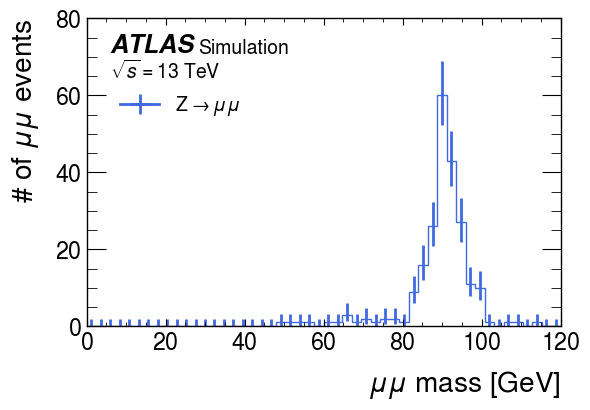

In [6]:
fig, ax = plt.subplots(1, figsize=(6, 4), dpi=100)

out["dimu_mass"].plot1d(ax=ax, color="royalblue")

hep.style.use([hep.style.ATLAS])
hep.atlas.label()

ax.legend(bbox_to_anchor=(0.01, 0.85), loc="upper left")

ax.set_ylabel('# of $\mu\mu$ events')
plt.show()